# 1. keras-Application
- https://keras.io/api/applications/
- 선행학습된 가중치와 함께 사용할 수 있도록 제공되는 딥러닝 모델

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
import pandas as pd
import numpy as np
import math
import cv2
import albumentations as A
import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetB0

In [2]:
# imagenet : 특정 사진을 보여줬을 때 이 사진이 무엇인지 맞출 수 있는 프로젝트에서 시작된 모델
# include_top : 상단에 Fully connected 계층을 포함할지 여부 (False인 경우 뒤쪽)

def get_model(input_shape) :
    inputs = keras.Input(input_shape)
    base_model = EfficientNetB0(
        input_shape = input_shape,
        weights = 'imagenet',
        include_top = False,
        pooling = 'avg'
    )
    
    x = base_model(inputs)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, output)
    return model

In [3]:
input_shape = (256, 256, 3)
model = get_model(input_shape)

Metal device set to: Apple M1 Max


2022-06-07 19:38:22.614860: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 19:38:22.615273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
adam = keras.optimizers.Adam(lr=0.0001)

/Users/woojaejoo/miniforge3/envs/env_tf2/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
model.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


In [7]:
class Augmentation :
    def __init__(self, size, mode='train') :
        if mode == 'train' :
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1*size),
                    max_width=int(0.1*size)
                ),
                A.RandomBrightnessContrast(p=0.2)
            ])
            
    def __call__(self, **kwargs) : # **kwargs : 매개변수의 개수에 상관없이 Dictionary로 바꿔준다.
        if self.transform :
            augmented = self.transform(**kwargs)
            img = augmented['image']
            
            return img

In [8]:
class DataGenerator(keras.utils.Sequence) :
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True) :
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train' :
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val' :
            self.df = self.df[self.df['fold'] == self.fold]
            
            
        #https://github.com/tensorflow/models/issues/3134
        
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
            
        self.on_epoch_end()
    
    # sample() : 전체 row(행)에서 몇 %의 데이터를 return 할 것인지 설정
    # frac : 데이터프레임으로 부터 특정 비율로 무작위 표본 추출을 하고 싶으면 0 ~ 1 사이의 부동소수점을 입력
    # reset_index() : drop = True 옵션을 설정하면 인덱스 열을 보통의 자료열로 설정하는 것이 아니라 버림
    def on_epoch_end(self) :
        if self.shuffle :
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    # len()
    def __len__(self) :
        return math.ceil(len(self.df) / self.batch_size) # ceil 올림
    
    # 클래스의 인덱스 접근할 떄 자동으로 호출되는 메소드
    def __getitem__(self, idx) :
        start = idx * self.batch_size
        end = (idx+1) * self.batch_size
        data = self.df.iloc[start:end]
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    # batch 만큼의 데이터들을 가져온다
    def get_data(self, data) :
        batch_x = []
        batch_y = []
        
        # 데이터 프레임에서 row의 개수만큼 반복
        # 튜플로 리턴(index, 행정보(Series))
        
        for _, r in data.iterrows() :
            file_name = r['file_name']
            image = cv2.imread(f'1_data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            
            if self.mode == 'train' :
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')
            image = image/255.
            
            label = int(r['species']) -1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

In [9]:
csv_path = './1_data/kfolds.csv'

#def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True)
train_generator = DataGenerator(
    batch_size = 64,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 64,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

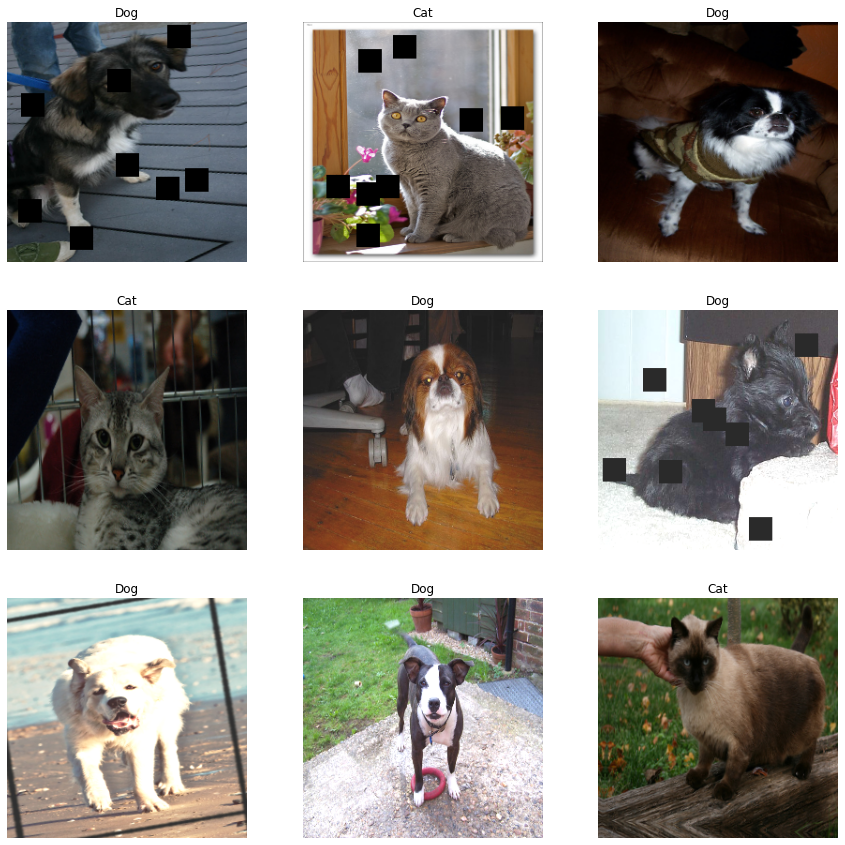

In [19]:
class_name = ['Cat', 'Dog']


for batch in train_generator : # 부모 클래스의 상속으로인해 한 배치씩 데이터를 넘겨준다.
    X, y = batch
    plt.figure(figsize=(15,15))
    
    for i in range(9) :
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
        
    break

In [20]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2022-06-05 19:08:33.163425: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-05 19:08:36.420470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9200

2022-06-05 19:09:45.884946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 80s 718ms/step - loss: 0.2285 - accuracy: 0.9200 - val_loss: 0.7650 - val_accuracy: 0.3222
Epoch 2/10
92/92 [==============================] - 58s 569ms/step - loss: 0.0544 - accuracy: 0.9825 - val_loss: 0.7548 - val_accuracy: 0.4523
Epoch 3/10
92/92 [==============================] - 46s 491ms/step - loss: 0.0349 - accuracy: 0.9881 - val_loss: 0.7367 - val_accuracy: 0.3760
Epoch 4/10
92/92 [==============================] - 46s 493ms/step - loss: 0.0254 - accuracy: 0.9918 - val_loss: 0.8733 - val_accuracy: 0.3590
Epoch 5/10
92/92 [==============================] - 46s 495ms/step - loss: 0.0205 - accuracy: 0.9930 - val_loss: 0.9612 - val_accuracy: 0.4285
Epoch 6/10
92/92 [==============================] - 47s 510ms/step - loss: 0.0168 - accuracy: 0.9949 - val_loss: 0.8199 - val_accuracy: 0.3236
Epoch 7/10
92/92 [==============================] - 48s 521ms/step - loss: 0.0144 - accuracy: 0.9946 - val_loss: 0.5614 - val_accuracy: 0.7044
Epoch 8/10